# disaster-tweets-classifier
Predict which Tweets are about real disasters and which ones are not with BERT  
https://www.kaggle.com/competitions/nlp-getting-started

## Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import library

In [2]:
# Most basic stuff for EDA.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Core packages for text processing.

import string
import re

# Libraries for text preprocessing.

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

# Loading some sklearn packaces for modelling.

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import f1_score, accuracy_score

# Some packages for word clouds and NER.

from wordcloud import WordCloud, STOPWORDS
from collections import Counter, defaultdict
from PIL import Image
import spacy
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.5/en_core_web_sm-2.2.5.tar.gz
!pip install spacytextblob
!python -m textblob.download_corpora
!python -m spacy download en_core_web_sm
import en_core_web_sm

# Core packages for general use throughout the notebook.

import random
import warnings
import time
import datetime

# For customizing our plots.

from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

# Loading pytorch packages.
import torch

!pip install transformers
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 17.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.2.5-py3-none-any.whl size=12011718 sha256=aa62de42d67efb65219f621932a4c6d9c8f5e728ef5bf35880badb5671afc7b8
  Stored in directory: /root/.cache/pip/wheels/28/45/a9/c35b2107f053046bd5ac0b1adb5ea970938b02b134e49b9a06
Successfully built en-core-web-sm
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 3.6.0
    Uninstalling en-core-web-sm-3.6.0:
      Successfully uninstalled en-core-web-sm-3.6.0
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_percep

In [3]:
# Setting some options for general use.

stop = set(stopwords.words('english'))
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5)
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
warnings.filterwarnings('ignore')


#Setting seeds for consistent results.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

## Load dataset

In [4]:
base_path = "drive/MyDrive/kaggle/disaster-tweets-classifier"
train_df = pd.read_csv(os.path.join(base_path, "train.csv"))
test_df = pd.read_csv(os.path.join(base_path, "test.csv"))

In [5]:
display(train_df.sample(5))
display(test_df.sample(5))

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


,id,keyword,location,text
142,449,armageddon,1996???????????,UNIVERSAL ORDER OF ARMAGEDDON http://t.co/3tY4mGm
2672,8915,snowstorm,Los Angeles,@BigBang_CBS ...wow...ok...um...that was like ...
2605,8682,sinkhole,"New York, New York",The sinkhole that ate Brooklyn http://t.co/28r...
2515,8381,ruin,"Monroe, OH",Don't ruin a good today by thinking about a ba...
958,3187,deluge,"West Powelton, Philadelphia",I'm havin previous life flashbacks of when i l...


In [6]:
print(train_df.shape)
print(test_df.shape)

(7613, 5)
(3263, 4)


## Cleaning Text


### Remove urls, emojis, html tags and punctuations

In [7]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

In [8]:
train_df['text'] = train_df['text'].apply(lambda x: remove_URL(x))
train_df['text'] = train_df['text'].apply(lambda x: remove_emoji(x))
train_df['text'] = train_df['text'].apply(lambda x: remove_html(x))
train_df['text'] = train_df['text'].apply(lambda x: remove_punct(x))

### Tokenize

In [9]:
train_df['tokenized'] = train_df['text'].apply(word_tokenize)

train_df.head()

,id,keyword,location,text,target,tokenized
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1,"[Our, Deeds, are, the, Reason, of, this, earth..."
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1,"[Forest, fire, near, La, Ronge, Sask, Canada]"
2,5,NaN,NaN,All residents asked to shelter in place are be...,1,"[All, residents, asked, to, shelter, in, place..."
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1,"[13000, people, receive, wildfires, evacuation..."
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1,"[Just, got, sent, this, photo, from, Ruby, Ala..."


### Lower casing clean text

In [10]:
train_df['tokenized'] = train_df['tokenized'].apply(
    lambda x: [word.lower() for word in x])

### Removing stopwords

In [11]:
train_df['tokenized'] = train_df['tokenized'].apply(
    lambda x: [word for word in x if word not in stop])

### Get speech tags

In [12]:
train_df['pos_tags'] = train_df['tokenized'].apply(nltk.tag.pos_tag)
train_df.head()

,id,keyword,location,text,target,tokenized,pos_tags
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1,"[deeds, reason, earthquake, may, allah, forgiv...","[(deeds, NNS), (reason, NN), (earthquake, NN),..."
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1,"[forest, fire, near, la, ronge, sask, canada]","[(forest, JJS), (fire, NN), (near, IN), (la, J..."
2,5,NaN,NaN,All residents asked to shelter in place are be...,1,"[residents, asked, shelter, place, notified, o...","[(residents, NNS), (asked, VBD), (shelter, JJ)..."
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1,"[13000, people, receive, wildfires, evacuation...","[(13000, CD), (people, NNS), (receive, JJ), (w..."
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1,"[got, sent, photo, ruby, alaska, smoke, wildfi...","[(got, VBD), (sent, JJ), (photo, NN), (ruby, N..."


### Converting part of speeches to wordnet format

In [13]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


train_df['wordnet_pos'] = train_df['pos_tags'].apply(
    lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

train_df.head()

,id,keyword,location,text,target,tokenized,pos_tags,wordnet_pos
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1,"[deeds, reason, earthquake, may, allah, forgiv...","[(deeds, NNS), (reason, NN), (earthquake, NN),...","[(deeds, n), (reason, n), (earthquake, n), (ma..."
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1,"[forest, fire, near, la, ronge, sask, canada]","[(forest, JJS), (fire, NN), (near, IN), (la, J...","[(forest, a), (fire, n), (near, n), (la, a), (..."
2,5,NaN,NaN,All residents asked to shelter in place are be...,1,"[residents, asked, shelter, place, notified, o...","[(residents, NNS), (asked, VBD), (shelter, JJ)...","[(residents, n), (asked, v), (shelter, a), (pl..."
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1,"[13000, people, receive, wildfires, evacuation...","[(13000, CD), (people, NNS), (receive, JJ), (w...","[(13000, n), (people, n), (receive, a), (wildf..."
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1,"[got, sent, photo, ruby, alaska, smoke, wildfi...","[(got, VBD), (sent, JJ), (photo, NN), (ruby, N...","[(got, v), (sent, a), (photo, n), (ruby, n), (..."


### Word lemmatize

In [14]:
wnl = WordNetLemmatizer()

train_df['lemmatized'] = train_df['wordnet_pos'].apply(
    lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

train_df['lemmatized'] = train_df['lemmatized'].apply(
    lambda x: [word for word in x if word not in stop])

train_df['lemma_str'] = [' '.join(map(str, l)) for l in train_df['lemmatized']]

train_df.head()

,id,keyword,location,text,target,tokenized,pos_tags,wordnet_pos,lemmatized,lemma_str
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1,"[deeds, reason, earthquake, may, allah, forgiv...","[(deeds, NNS), (reason, NN), (earthquake, NN),...","[(deeds, n), (reason, n), (earthquake, n), (ma...","[deed, reason, earthquake, may, allah, forgive...",deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1,"[forest, fire, near, la, ronge, sask, canada]","[(forest, JJS), (fire, NN), (near, IN), (la, J...","[(forest, a), (fire, n), (near, n), (la, a), (...","[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to shelter in place are be...,1,"[residents, asked, shelter, place, notified, o...","[(residents, NNS), (asked, VBD), (shelter, JJ)...","[(residents, n), (asked, v), (shelter, a), (pl...","[resident, ask, shelter, place, notify, office...",resident ask shelter place notify officer evac...
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1,"[13000, people, receive, wildfires, evacuation...","[(13000, CD), (people, NNS), (receive, JJ), (w...","[(13000, n), (people, n), (receive, a), (wildf...","[13000, people, receive, wildfire, evacuation,...",13000 people receive wildfire evacuation order...
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1,"[got, sent, photo, ruby, alaska, smoke, wildfi...","[(got, VBD), (sent, JJ), (photo, NN), (ruby, N...","[(got, v), (sent, a), (photo, n), (ruby, n), (...","[get, sent, photo, ruby, alaska, smoke, wildfi...",get sent photo ruby alaska smoke wildfires pou...


## Visualizing the Data

### Most Common Words

In [15]:
def show_word_cloud(words, title):
  allwords = []
  for wordlist in words:
      allwords += wordlist
  mostcommon = FreqDist(allwords).most_common(140)
  wordcloud = WordCloud(
          width=1200,
          height=800,
          background_color='white',
          stopwords=set(STOPWORDS),
          max_words=150,
          scale=3,
          contour_width=0.1,
          colormap="winter"
      ).generate(str(mostcommon))

  plt.figure(figsize=(15,10))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.title(title)
  plt.show()

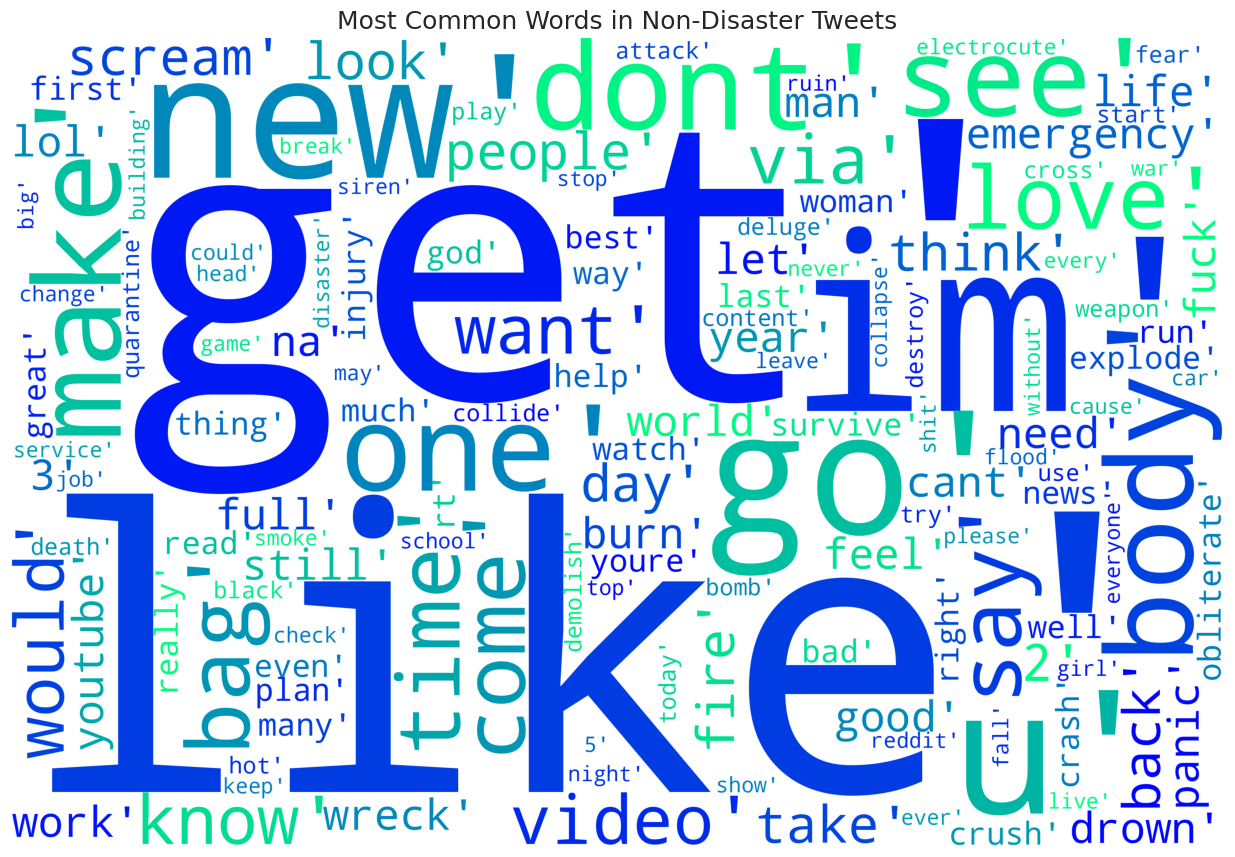

In [16]:
show_word_cloud(train_df[train_df['target'] == 0]['lemmatized'], 'Most Common Words in Non-Disaster Tweets')

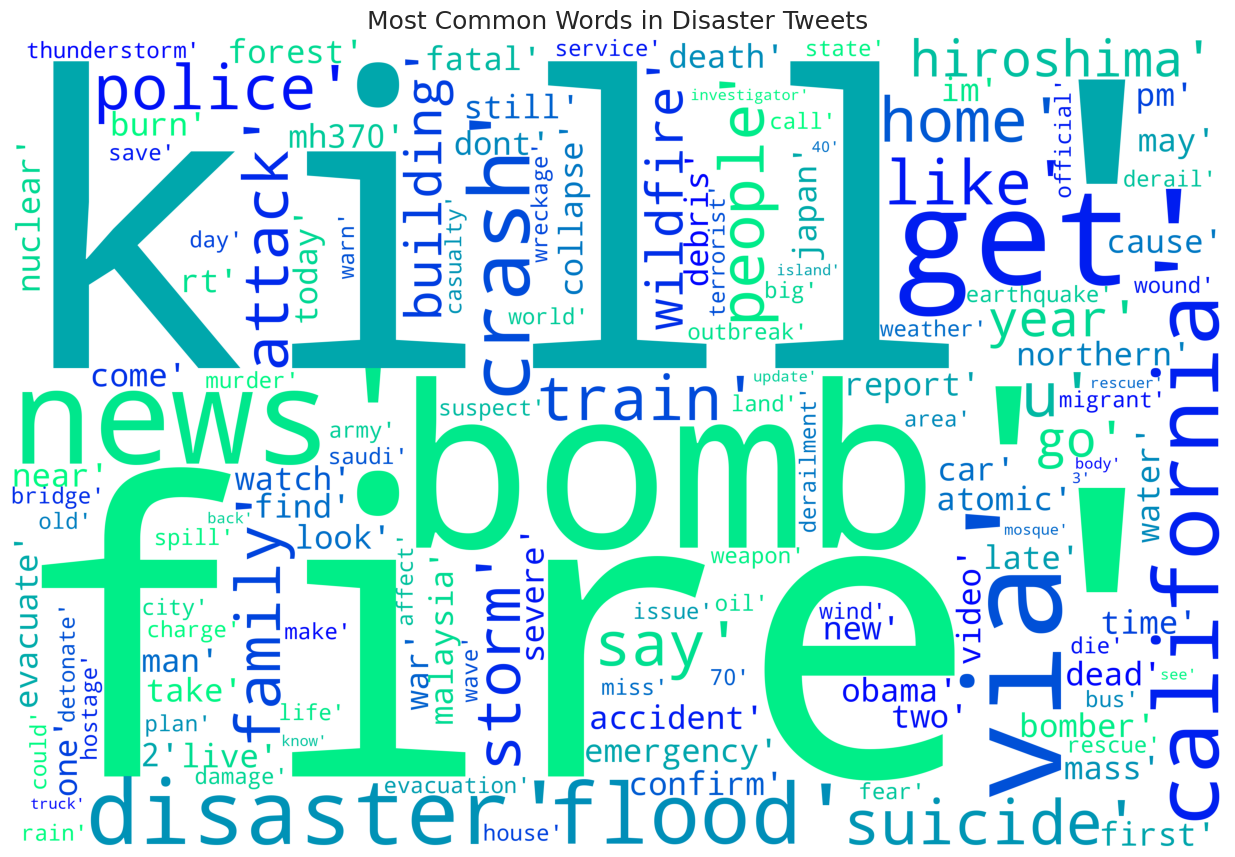

In [17]:
show_word_cloud(train_df[train_df['target'] == 1]['lemmatized'], 'Most Common Words in Disaster Tweets')

### Named Entity Recognition

In [18]:
nlp = en_core_web_sm.load()

In [19]:
def plot_named_entity_barchart(text):

    """A function for extracting named entities and comparing them"""

    def _get_ner(text):
        doc = nlp(text)
        return [X.label_ for X in doc.ents]

    ent = text.apply(lambda x: _get_ner(x))
    ent = [x for sub in ent for x in sub]
    counter = Counter(ent)
    count = counter.most_common()

    x, y = map(list, zip(*count))
    sns.barplot(x=y, y=x)

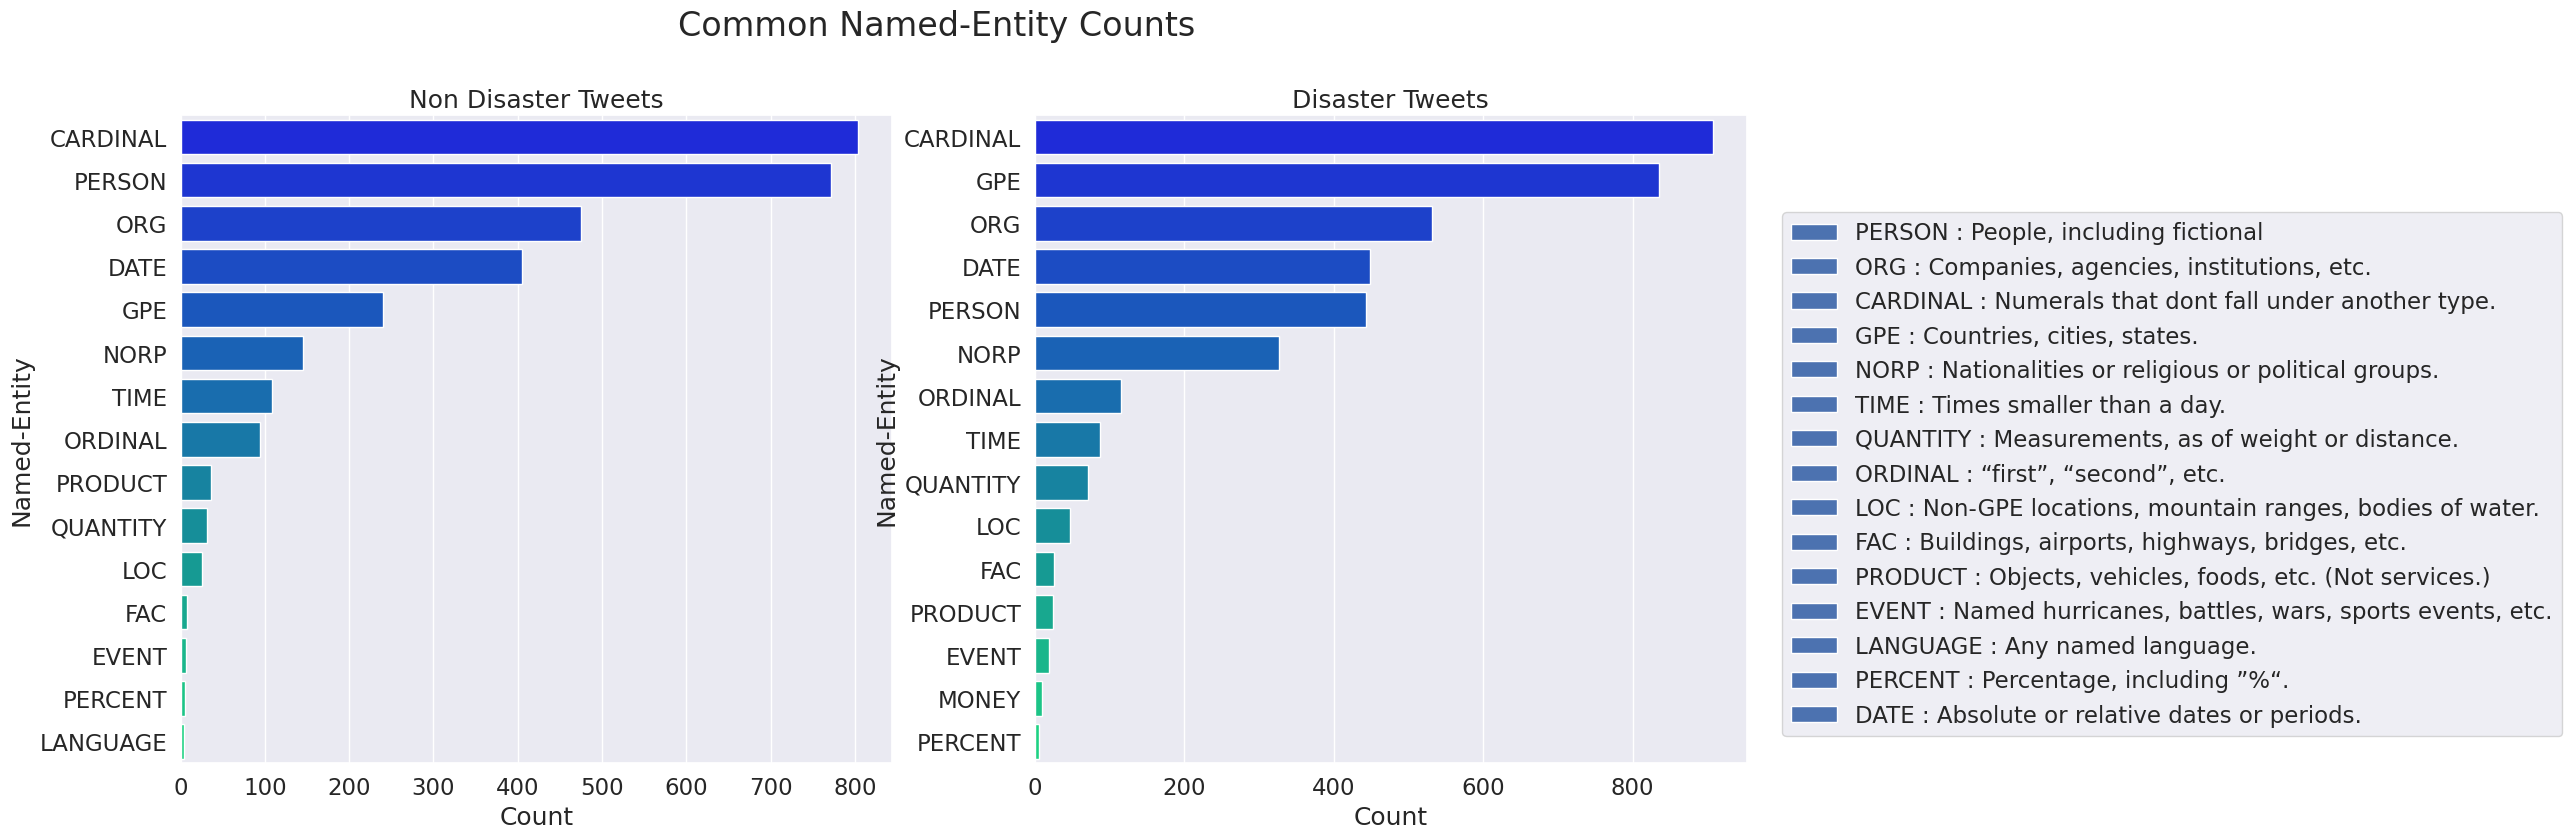

In [20]:
lis = [
    train_df[train_df['target'] == 0]['lemma_str'],
    train_df[train_df['target'] == 1]['lemma_str']
]
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()
for i, j in zip(lis, axes):

    def _get_ner(i):
        doc = nlp(i)
        return [X.label_ for X in doc.ents]

    ent = i.apply(lambda x: _get_ner(x))
    ent = [x for sub in ent for x in sub]
    counter = Counter(ent)
    count = counter.most_common()[:15]

    x, y = map(list, zip(*count))
    sns.barplot(x=y, y=x, ax=j, palette='winter')

axes[0].set_title('Non Disaster Tweets')
axes[1].set_title('Disaster Tweets')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Named-Entity')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Named-Entity')
fig.suptitle('Common Named-Entity Counts', fontsize=24, va='baseline')



patch1 = mpatches.Patch(label='PERSON : People, including fictional')
patch2 = mpatches.Patch(label='ORG : Companies, agencies, institutions, etc.')
patch3 = mpatches.Patch(label='CARDINAL : Numerals that dont fall under another type.')
patch4 = mpatches.Patch(label='GPE : Countries, cities, states.')
patch5 = mpatches.Patch(label='NORP : Nationalities or religious or political groups.')
patch6 = mpatches.Patch(label='TIME : Times smaller than a day.')
patch7 = mpatches.Patch(label='QUANTITY : Measurements, as of weight or distance.')
patch8 = mpatches.Patch(label='ORDINAL : “first”, “second”, etc.')
patch9 = mpatches.Patch(label='LOC : Non-GPE locations, mountain ranges, bodies of water.')
patch10 = mpatches.Patch(label='FAC : Buildings, airports, highways, bridges, etc.')
patch11 = mpatches.Patch(label='PRODUCT : Objects, vehicles, foods, etc. (Not services.)')
patch12 = mpatches.Patch(label='EVENT : Named hurricanes, battles, wars, sports events, etc.')
patch13 = mpatches.Patch(label='LANGUAGE : Any named language.')
patch14 = mpatches.Patch(label='PERCENT : Percentage, including ”%“.')
patch15 = mpatches.Patch(label='DATE : Absolute or relative dates or periods.')



plt.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6, patch7, patch8, patch9, patch10, patch11, patch12, patch13, patch14, patch15, ],bbox_to_anchor=(1.05, 0.85), loc='upper left', borderaxespad=0.)

plt.show()

## Building the Bert Model

In [21]:
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.

    device = torch.device('cuda')


    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [22]:
train = pd.read_csv(os.path.join(base_path, "train.csv"))
test = pd.read_csv(os.path.join(base_path, "test.csv"))

print(f'Number of training tweets: {train.shape[0]}\n')
print(f'Number of training tweets: {test.shape[0]}\n')

display(train.sample(10))

Number of training tweets: 7613

Number of training tweets: 3263



,id,keyword,location,text,target
217,309,annihilated,"Greater Manchester, UK",@ACarewornHeart Have a good un fella sorry I w...,0
6688,9582,thunder,NaN,Thunder lightening torrential rain and a power...,1
2687,3855,detonation,NaN,Dorman 917-033 Ignition Knock (Detonation) Sen...,1
5060,7211,natural%20disaster,liaÛ¢daniÛ¢laura,Rise up like a natural disaster we take the ba...,0
6855,9826,trauma,NaN,Trauma injuries involving kids and sport usual...,1
563,814,battle,NaN,A young German stormtrooper engaged in the Bat...,1
2431,3493,derailed,United Kingdom,#tubestrike derailed you? Our #robertwelch cut...,0
2928,4209,drowned,NaN,@ABCNews24 @PeterDutton_MP \nHe also told you....,0
3400,4868,explode,London / Berlin / Online,'I eat because it makes my mouth explode with ...,0
6258,8942,storm,NaN,FINALLY a storm,0


### Setting target variables, creating combined data and saving index for dividing combined data later

In [23]:
labels = train['target'].values
idx = len(labels)
combined = pd.concat([train, test])
combined = combined.text.values

### Tokenizing the combined text data using bert tokenizer

In [24]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

In [25]:
# Print the original tweet.

print(' Original: ', combined[0])

# Print the tweet split into tokens.

print('Tokenized: ', tokenizer.tokenize(combined[0]))

# Print the sentence mapped to token ID's.

print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(combined[0])))

 Original:  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Tokenized:  ['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', '#', 'earthquake', 'may', 'allah', 'forgive', 'us', 'all']
Token IDs:  [2256, 15616, 2024, 1996, 3114, 1997, 2023, 1001, 8372, 2089, 16455, 9641, 2149, 2035]


In [26]:
max_len = 0

# For every sentence...

for text in combined:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.

    input_ids = tokenizer.encode(text, add_special_tokens=True)

    # Update the maximum sentence length.

    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  84


In [27]:
# Making list of sentence lenghts:

token_lens = []

for text in combined:
    tokens = tokenizer.encode(text, max_length = 512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


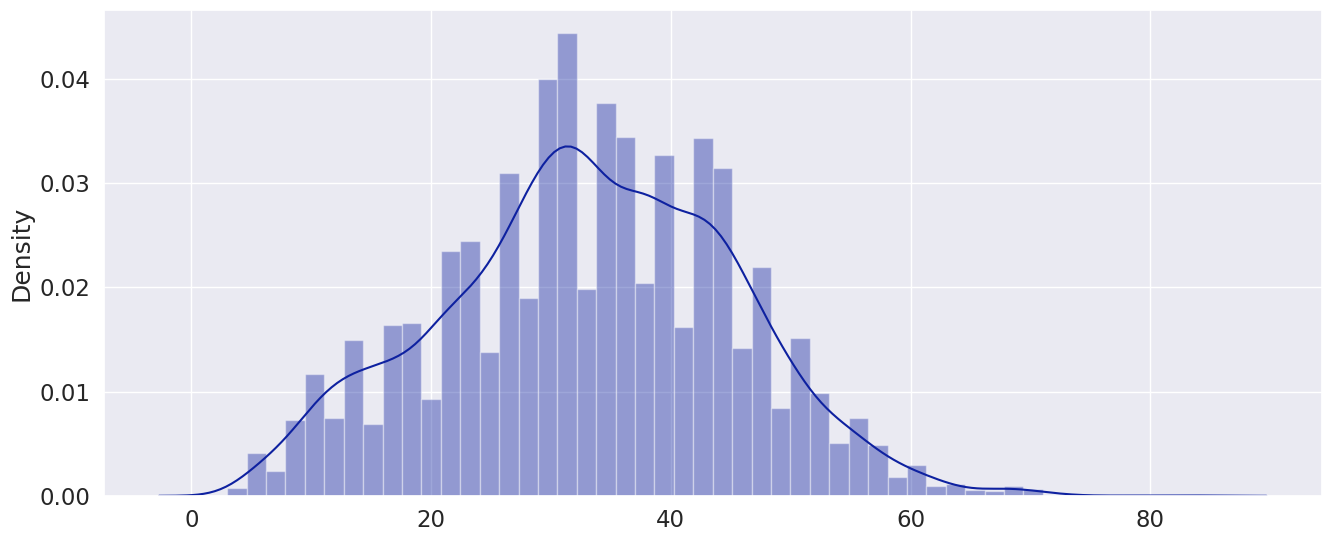

In [28]:
# Displaying sentence length dist.

fig, axes = plt.subplots(figsize=(14, 6))
sns.distplot(token_lens, color='#0E21A0')
plt.show()

In [29]:
train= combined[:idx]
test = combined[idx:]
train.shape

(7613,)

In [30]:
def tokenize_map(sentence,labs='None'):

    """A function for tokenize all of the sentences and map the tokens to their word IDs."""

    global labels

    input_ids = []
    attention_masks = []

    # For every sentence...

    for text in sentence:
        #   "encode_plus" will:

        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.

        encoded_dict = tokenizer.encode_plus(
                            text,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            truncation='longest_first', # Activate and control truncation
                            max_length = 84,           # Max length according to our text data.
                            pad_to_max_length = True, # Pad & truncate all sentences.
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

        # Add the encoded sentence to the id list.

        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).

        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    if labs != 'None': # Setting this for using this definition for both train and test data so labels won't be a problem in our outputs.
        labels = torch.tensor(labels)
        return input_ids, attention_masks, labels
    else:
        return input_ids, attention_masks

In [31]:
# Tokenizing all of the train test sentences and mapping the tokens to their word IDs.

input_ids, attention_masks, labels = tokenize_map(train, labels)
test_input_ids, test_attention_masks= tokenize_map(test)

In [32]:
# Combine the training inputs into a TensorDataset.

dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-20 train-validation split.

# Calculate the number of samples to include in each set.

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

6,090 training samples
1,523 validation samples


In [33]:
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.

train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.

validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [34]:
prediction_data = TensorDataset(test_input_ids, test_attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

### Setting the Bert Classification Model

In [35]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.

model = BertForSequenceClassification.from_pretrained(
    'bert-large-uncased', # Use the 124-layer, 1024-hidden, 16-heads, 340M parameters BERT model with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification. You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,

In [36]:
# Get all of the model's parameters as a list of tuples:

params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

The BERT model has 393 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 1024)
bert.embeddings.position_embeddings.weight               (512, 1024)
bert.embeddings.token_type_embeddings.weight               (2, 1024)
bert.embeddings.LayerNorm.weight                             (1024,)
bert.embeddings.LayerNorm.bias                               (1024,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight        (1024, 1024)
bert.encoder.layer.0.attention.self.query.bias               (1024,)
bert.encoder.layer.0.attention.self.key.weight          (1024, 1024)
bert.encoder.layer.0.attention.self.key.bias                 (1024,)
bert.encoder.layer.0.attention.self.value.weight        (1024, 1024)
bert.encoder.layer.0.attention.self.value.bias               (1024,)
bert.encoder.layer.0.attention.output.dense.weight      (1024, 1024)
bert.encoder.layer.0.attention.output.dense.bias             (

In [37]:
optimizer = AdamW(model.parameters(),
                  lr = 6e-6, # args.learning_rate
                  eps = 1e-8 # args.adam_epsilon
                )

In [38]:
epochs = 3

# Total number of training steps is [number of batches] x [number of epochs] (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

### Training and Evaluating

In [39]:
def flat_accuracy(preds, labels):

    """A function for calculating accuracy scores"""

    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return accuracy_score(labels_flat, pred_flat)

def flat_f1(preds, labels):

    """A function for calculating f1 scores"""

    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return f1_score(labels_flat, pred_flat)

In [40]:
def format_time(elapsed):

    """A function that takes a time in seconds and returns a string hh:mm:ss"""

    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [42]:
# This training code is based on the `run_glue.py` script here:

# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# We'll store a number of quantities such as training and validation loss, validation accuracy, f1 score and timings.

training_stats = []

# Measure the total training time for the whole run.

total_t0 = time.time()

# For each epoch...

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print('')
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes:

    t0 = time.time()

    # Reset the total loss for this epoch.

    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to `train` just changes the *mode*, it doesn't *perform* the training.

    # `dropout` and `batchnorm` layers behave differently during training vs. test ,
    # source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch

    model.train()

    # For each batch of training data...

    for step, batch in enumerate(train_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the device(gpu in our case) using the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels

        b_input_ids = batch[0].to(device).to(torch.int64)
        b_input_mask = batch[1].to(device).to(torch.int64)
        b_labels = batch[2].to(device).to(torch.int64)

        # Always clear any previously calculated gradients before performing a backward pass. PyTorch doesn't do this automatically because accumulating the gradients is 'convenient while training RNNs'.
        # Source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch

        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is down here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers BertForSequenceClassification.

        # It returns different numbers of parameters depending on what arguments given and what flags are set. For our useage here, it returns the loss (because we provided labels),
        # And the 'logits' (the model outputs prior to activation.)

        r = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)
        loss = r.loss
        logits = r.logits

        # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end,
        # `loss` is a tensor containing a single value; the `.item()` function just returns the Python value from the tensor.

        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.

        loss.backward()

        # Clip the norm of the gradients to 1.0 This is to help prevent the 'exploding gradients' problem.

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.

        # The optimizer dictates the 'update rule'(How the parameters are modified based on their gradients, the learning rate, etc.)

        optimizer.step()

        # Update the learning rate.

        scheduler.step()

    # Calculate the average loss over all of the batches.

    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.

    training_time = format_time(time.time() - t0)

    print('')
    print('  Average training loss: {0:.2f}'.format(avg_train_loss))
    print('  Training epcoh took: {:}'.format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on our validation set.

    print('')
    print('Running Validation...')

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently during evaluation.

    model.eval()

    # Tracking variables:

    total_eval_accuracy = 0
    total_eval_loss = 0
    total_eval_f1 = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch.

    for batch in validation_dataloader:

        # Unpack this training batch from our dataloader.

        # As we unpack the batch, we'll also copy each tensor to the GPU using the `to` method.

        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during the forward pass, since this is only needed for backprop (training part).

        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the 'segment ids', which differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is down here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers BertForSequenceClassification.
            # Get the 'logits' output by the model. The 'logits' are the output values prior to applying an activation function like the softmax.

            r = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)
            loss = r.loss
            logits = r.logits

        # Accumulate the validation loss.

        total_eval_loss += loss.item()

        # Move logits and labels to CPU:

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and accumulate it over all batches:

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        total_eval_f1 += flat_f1(logits, label_ids)


    # Report the final accuracy for this validation run.

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print('  Accuracy: {0:.2f}'.format(avg_val_accuracy))

    # Report the final f1 score for this validation run.

    avg_val_f1 = total_eval_f1 / len(validation_dataloader)
    print('  F1: {0:.2f}'.format(avg_val_f1))

    # Calculate the average loss over all of the batches.

    avg_val_loss = total_eval_loss / len(validation_dataloader)



    # Measure how long the validation run took:

    validation_time = format_time(time.time() - t0)

    print('  Validation Loss: {0:.2f}'.format(avg_val_loss))
    print('  Validation took: {:}'.format(validation_time))

    # Record all statistics from this epoch.

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Val_F1' : avg_val_f1,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print('')
print('Training complete!')

print('Total training took {:} (h:mm:ss)'.format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    50  of    191.    Elapsed: 0:01:10.
  Batch   100  of    191.    Elapsed: 0:02:20.
  Batch   150  of    191.    Elapsed: 0:03:29.

  Average training loss: 0.37
  Training epcoh took: 0:04:25

Running Validation...
  Accuracy: 0.82
  F1: 0.78
  Validation Loss: 0.42
  Validation took: 0:00:22

======== Epoch 2 / 3 ========
Training...
  Batch    50  of    191.    Elapsed: 0:01:09.
  Batch   100  of    191.    Elapsed: 0:02:19.
  Batch   150  of    191.    Elapsed: 0:03:28.

  Average training loss: 0.32
  Training epcoh took: 0:04:24

Running Validation...
  Accuracy: 0.83
  F1: 0.78
  Validation Loss: 0.43
  Validation took: 0:00:23

======== Epoch 3 / 3 ========
Training...
  Batch    50  of    191.    Elapsed: 0:01:09.
  Batch   100  of    191.    Elapsed: 0:02:18.
  Batch   150  of    191.    Elapsed: 0:03:28.

  Average training loss: 0.31
  Training epcoh took: 0:04:24

Running Validation...
  Accuracy: 0.83
  F1: 0.78
  Valid

In [44]:
# Display floats with two decimal places.

pd.set_option('display.precision', 2)

# Create a DataFrame from our training statistics.

df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.

df_stats = df_stats.set_index('epoch')

# Display the table.

display(df_stats)

,Training Loss,Valid. Loss,Valid. Accur.,Val_F1,Training Time,Validation Time
epoch,,,,,,
1,0.37,0.42,0.82,0.78,0:04:25,0:00:22
2,0.32,0.43,0.83,0.78,0:04:24,0:00:23
3,0.31,0.43,0.83,0.78,0:04:24,0:00:23


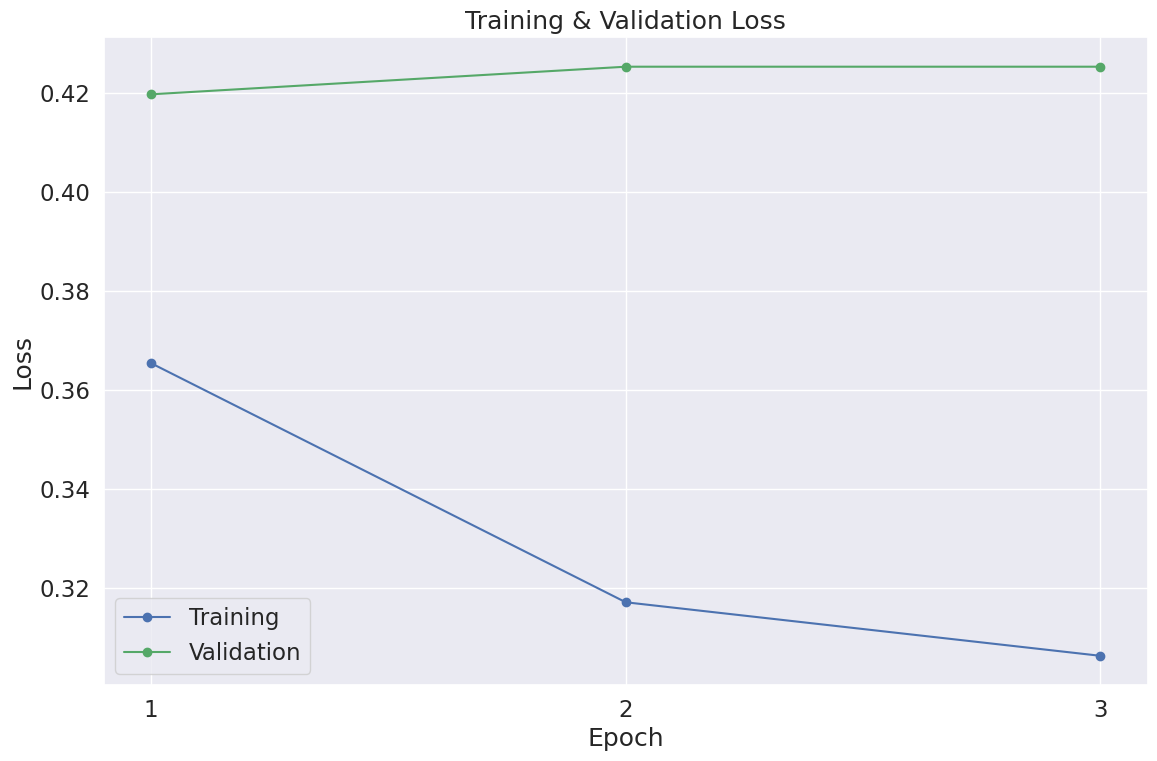

In [45]:


# Increase the plot size and font size:

fig, axes = plt.subplots(figsize=(12,8))

# Plot the learning curve:

plt.plot(df_stats['Training Loss'], 'b-o', label='Training')
plt.plot(df_stats['Valid. Loss'], 'g-o', label='Validation')

# Label the plot:

plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.xticks([1, 2, 3])

plt.show()



## Predicting and Submission

In [46]:
# Prediction on test set:

print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))

# Put model in evaluation mode:

model.eval()

# Tracking variables :

predictions = []

# Predict:

for batch in prediction_dataloader:

  # Add batch to GPU

  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader:

  b_input_ids, b_input_mask, = batch

  # Telling the model not to compute or store gradients, saving memory and speeding up prediction:

  with torch.no_grad():
      # Forward pass, calculate logit predictions:

      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU:

  logits = logits.detach().cpu().numpy()


  # Store predictions and true labels:

  predictions.append(logits)


print('    DONE.')

Predicting labels for 3,263 test sentences...
    DONE.


In [47]:
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

In [49]:
submission = pd.read_csv(os.path.join(base_path, "sample_submission.csv"))
submission['target'] = flat_predictions
submission.head(10)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


In [50]:
submission.to_csv(os.path.join(base_path, "submission.csv"), index=False, header=True)